In [3]:
import collections
import math
import string
import numpy as np
import pandas as pd
from itertools import permutations
from sympy.utilities.iterables import partitions
import matplotlib.pyplot as plt 
%matplotlib notebook
pd.set_option('precision', 7)

**Variables**

In [4]:
pi = [1/2, 1/3, 1/6]
p1 = {3:1, 2:1, 1:1}
p2 = {3:2}
p3 = {6:1}
p4 = {4:1, 1:2}
k=3
p_test = p4

---
**list_all_ints** is a helper function to type_probability

Input: the integer partition dictionary

Output: a list of the integers

```python
p = {3:1, 1:2}
col_names = [3, 1, 1]
```

In [5]:
def list_all_ints(p):
    col_names = []
    for i in p.keys(): # i = integer, m = multiplicity
        m = p[i]
        for x in range(m):
            col_names.append(i)
    return col_names

---
**type_3**

Input: 
- an integer partition p 
- pi, a list of probabilities per disease in k 
- k, the number of unique plaintext values/diseases

```python
p = {6:1}
pi = [.5, .333, .166]
k = 3
```

Output: 
- df, a dataframe. The first three columns are 'a', 'b', and 'c', the diseases.  The final column is the probability of the column's type. The rows represent the type of column.
- int_list, a expanded list of the integer partition. For example, if p = {3:2}, int_list = [3, 3]

An example of df:

|   -  | a | b | c | probs |
|---|--|---|---|-------|
| 0   | 6 | 0 | 0 | 0.0156250 |
| 1   | 0 | 0 | 6 | 0.0000214 |
| 2   | 0 | 6 | 0 | 0.0013717 |


Notes: 
- hardcoded for k = 3
- uses list_all_ints(p) as a helper function. 

Question:
- Should we take the set of the permutations or just the list of the permutations? For example, let's have the integer partition 4 + 1 + 1. The set would be {411, 141, 114) but the list would be {411, 411, 141, 141, 114, 114). 

The set option (in use currently) 

|   -  | a | b | c | ... |
|---|--|---|---|-------|
| 0   | 4 | 1 | 1 | ... |
| 1   | 1 | 4 | 1 | ... |
| 2   | 1 | 1 | 4 | ... |

The list option

|   -  | a | b | c | ... |
|---|--|---|---|-------|
| 0   | 4 | 1 | 1 | ... |
| 1   | 4 | 1 | 1 | ... |
| 2   | 1 | 4 | 1 | ... |
| 3   | 1 | 4 | 1 | ... |
| 4   | 1 | 1 | 4 | ... |
| 5   | 1 | 1 | 4 | ... |

In [6]:
def type_3(p, pi, k):
    int_list = list_all_ints(p)
    int_list.extend([0] * (k-len(int_list))) # pads list with 0s
    data = list(set(permutations(int_list, k)))
    df = pd.DataFrame(data = data, columns=['a', 'b','c'])
    df['prob'] = pow(pi[0], df['a']) * pow(pi[1], df['b']) * pow(pi[2], df['c'])
    return df, int_list

In [7]:
# Test of type_3 with different int partitions
my_df, my_int_list = type_3(p_test, pi, k)
print(my_df)

   a  b  c       prob
0  1  1  4  0.0001286
1  1  4  1  0.0010288
2  4  1  1  0.0034722


---
***choices_matrix()*** provides a matrix listing all the choices for a given integer partition and prior pi

Input:
- df: the dataframe with all possible types for the integer partition
- int_list: the expanded integer partition

Output:
- df_g, or dataframe_guess which contains the (not normalized) probabilities of every possible block in the integer partition being the respective diseases.

An example of df_g:

|   -  | a | b | c |
|---|--|---|---|
| 6   | 0.0156250 | 0.0013717 | 0.0000214 |
| 0   | 0.0013932 | 0.0156464 | 0.0169967 |
| 0   | 0.0013932 | 0.0156464 | 0.0169967 |

Question:
- In the case where there are two of the same integers (ex: 4 + 1 + 1), should we add the probabilities together? df_g for 4 + 1 + 1 looks like the following:

|   -  | a | b | c |
|---|--|---|---|
| 4   | 0.0034722 | 0.0010288 | 0.0001286
| 1   | 0.0011574 | 0.0036008 | 0.0045010
| 1   | 0.0011574 | 0.0036008 | 0.0045010

But is the probability that a block of size 1 == c .0045 or .009?

In [8]:
def choices_matrix(df, int_list):
    df_g = pd.DataFrame(0, index=int_list, columns=['a','b','c'])
    for i in int_list:
        df_g.loc[i,'a'] = df[df['a'] == i]['prob'].sum()
        df_g.loc[i,'b'] = df[df['b'] == i]['prob'].sum()
        df_g.loc[i,'c'] = df[df['c'] == i]['prob'].sum()
    return df_g

In [9]:
# Test of choices_matrix() w/type 3
my_df_guess = choices_matrix(my_df, my_int_list)
print(my_df_guess)

           a          b          c
4  0.0034722  0.0010288  0.0001286
1  0.0011574  0.0036008  0.0045010
1  0.0011574  0.0036008  0.0045010


---
***reduce_choices()*** reduces the size of the df_g matrix to only feasible answers and removes equal choices

Input:
- df_g, the matrix containing all of the possible choices
- p, the integer partition dictionary

Output:
- df_reduced_guess, a dataframe that indicates the possible unique choices an adversary choice make given an integer partition

In [10]:
def reduce_choices(df_g, p):
    data = []
    # if p[k] (multiplicity) >1, only take one row
    # only keep blocks > size 0 (where row index ! = 0)
    for k in p.keys(): # for every unique integer in p, copy a row in df_guess that matches the int
        if p[k] > 1: # choose first example if >1
            data.append(df_g.loc[k].iloc[0])# (old) .divide(p[k]))
        else:
            data.append(df_g.loc[k]) #copy the row
    df_reduced_guess = pd.DataFrame(data = data)
    return df_reduced_guess

In [11]:
my_reduced_df = reduce_choices(my_df_guess, p_test)
my_reduced_df.head()

,a,b,c
4,0.0034722,0.0010288,0.0001286
1,0.0011574,0.0036008,0.0045010


---
***choose_max()*** takes the reduced matrix and says which guess to make, along with the posterior vulnerability the integer partition provided

Input:
- df_reduced_guess, the reduced matrix of choices

Output:
- val, the contribution to the posterior vulnerability for one instance of one integer partition
- block_size, the block to guess about
- disease, the correct disease, or plaintext value, to guess

In [12]:
def choose_max(df_reduced_guess):
    col_max_values = df_reduced_guess.max() # per column, the max values
    col_max_values_id = df_reduced_guess.idxmax() # per column (disease), the index/block size of the max values
    val = col_max_values.max() # max of the column maximums
    disease = col_max_values.idxmax() # disease (column) of the above value
    block_size = col_max_values_id.loc[disease] # contribution to the posterior vuln by this integer partition
    return val, block_size, disease

In [13]:
# Tets of choose_max
my_val, my_block, my_disease = choose_max(my_reduced_df)
print("contribution of partition to posterior vuln: ", my_val)
print("*********The best choice is*********")
print("block size: ", my_block)
print("disease: ", my_disease)

contribution of partition to posterior vuln:  0.004501028806584362
*********The best choice is*********
block size:  1
disease:  c


---
**calc_index_partitions()** calculates number of index partitions given an integer n and a integer partition p

Input:
- n: positive integer, the size of the column
- p: a unique integer partition, as a python dictionary

Output:
- frac: the number of index partitions that can have integer partition p

Generalized formula:<br>
With an interger partition $p$ containing integers $i$, each with multiplicity of $m$,
$$\text{index partitions}(n,p)=\frac{n!}{\prod_{i \in p} i!^m m!}$$

Example:<br>
$$\text{index partitions}(6,\{4:1, 1:2\}) = \frac{6!}{\left(4!\right)1! \times \left(1!\right)^2 2!} $$

In [14]:
def calc_index_partitions(n,p):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        m = p[i]
        den = den * pow(math.factorial(i), m) * math.factorial(m)
    frac = num / den
    return frac

---
**post_vuln()** calculates the posterior gain vulnerability

Input:
- n: the size of the column (number of patients)
- k: the number of plaintext values (diseases)
- pi: the probability distrubution of the values in k

Output:
- pgvsum: the posterior gain vulnerability for that n value
- choices_df: a dataframe where every row represents a different integer partition and contains the number of index partitions given the integer partition, the correct block and disease guess, the per integer partition contribution to the posterior gain vulnerability, and the weighted contribution to the posterior gain vulnerability (by the number of index partitions)

Notes:
- Due to the helper functions, this is hardcoded for k = 3

In [38]:
def post_vuln(n, k, pi):
    pgvsum = 0
    data = []
    for p in partitions(n, m=k): 
        p_guess = {}
        num_index_partitions = calc_index_partitions(n,p) # p's number of index partitions
        df, int_list = type_3(p, pi, k) # the probabilities of different types of the column
        df_g = choices_matrix(df, int_list) # the disease:block size guesses the adversary can make
        df_reduced = reduce_choices(df_g, p) # reduced dataframe, no 0s or duplicates
        contribution, block_size, disease = choose_max(df_reduced) # the posterior vuln for one instance of this p, and the best guess
        weighted = num_index_partitions * contribution
        pgvsum = pgvsum + weighted
        p_guess = {'partition': int_list, 'contribution': contribution, 'indexes': num_index_partitions, 'block_size': block_size, 'disease': disease, 'weighted': weighted}
        data.append(p_guess)
    choices_df = pd.DataFrame(data = data)
    return pgvsum, choices_df

In [84]:
print("posterior gain vulnerability for n = %s " % n)
n = 6
post, choices_df = post_vuln(n, k, pi)
print(post)

posterior gain vulnerability for n = 6 
0.6022376543209876


In [40]:
choices_df

,block_size,contribution,disease,indexes,partition,weighted
0,6,0.0156250,a,1.0,"[6, 0, 0]",0.0156250
1,5,0.0156250,a,6.0,"[5, 1, 0]",0.0937500
2,4,0.0086806,a,15.0,"[4, 2, 0]",0.1302083
3,1,0.0045010,c,15.0,"[4, 1, 1]",0.0675154
4,3,0.0052083,a,10.0,"[3, 3, 0]",0.0520833
5,1,0.0038580,c,60.0,"[3, 2, 1]",0.2314815
6,2,0.0007716,a,15.0,"[2, 2, 2]",0.0115741


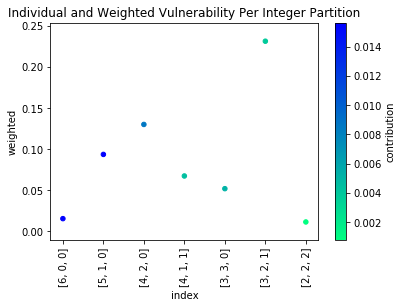

" \nGraph options w/o colormap\nchoices_df.plot(x='partition', \n                y='weighted',\n                style='o-')\nplt.xticks(choices_df.index, choices_df['partition'], rotation=90)\nplt.show()\n"

In [86]:
fig, ax = plt.subplots() # to show xtick labels
choices_df.reset_index().plot.scatter(x='index', 
                y='weighted',
                c = 'contribution', # the color map scale
                colormap='winter_r',
                ax = ax)
plt.xticks(choices_df.index, choices_df['partition'], rotation=90)
plt.title("Individual and Weighted Vulnerability Per Integer Partition")
plt.show()

''' 
Graph options w/o colormap
choices_df.plot(x='partition', 
                y='weighted',
                style='o-')
plt.xticks(choices_df.index, choices_df['partition'], rotation=90)
plt.show()
'''

### Tests

In [18]:
my_int_list = [3, 3, 0]
my_list = list(set(permutations(my_int_list, k)))
print(my_list)

[(3, 3, 0), (0, 3, 3), (3, 0, 3)]


In [ ]:
n = 6
k = 3
for p in partitions(n, m = k):
    print("p = ", p)
    print("p.keys()= ", p.keys())
    for k in p.keys():
        print("value: ", p[k])
    num = calc_set_partitions(n,p)
    print("index_partitions: ", num)

### Trash

**k_dictionary**

Input: pi, the probability distribution

Output: a dictionary with letters for keys. The letters represent individual diseases. Can be used to keep track of individual diseases throughout the gain function calculations.

Note-- Not currently in use

```python
pi = [1/2, 1/3, 1/6]
k_dict = {'a': 0.5, 'b': 0.33333, 'c':0.166666}
```

In [ ]:
def k_dictionary(pi):
    return dict(zip(string.ascii_lowercase, pi))

In [ ]:
pi_dictionary = k_dictionary(pi)

print(pi_dictionary)

In [ ]:
def type_1(p, pi):
    '''
    We use the int partition p to calculate 
    1. the number of bins and 
    2. the column names for the dataframe
    '''
    bins = sum(p.values()) #there will always be <=k 'bins' 
    col_names = list_all_ints(p)
    df = pd.DataFrame(list(permutations(pi, bins)), columns=col_names)
    df['prob'] = pow(df[col_names[0]],col_names[0]) *  pow(df[col_names[1]],col_names[1]) *  pow(df[col_names[2]],col_names[2])
    return df

In [ ]:
df = type_1({3:1, 2:1, 1:1}, pi)
print(df)